# CS376 HW1 ***(Total score: 50)***

# Submission Guideline

**1. How to submit**
*   Fill out <mark> TODO</mark> blocks, **DO NOT** modify other parts of the skeleton code.
*   Submit two files: hw1_{student_ID}.ipynb, hw1_{student_ID}.pdf to KLMS

    e.g. hw1_20221234.ipynb, hw1_20221234.pdf

**2. Note**
*   Both ipynb and PDF files must contain executed log of all code blocks (after the last execution).
*   Your code should be reproducable. If we cannot reproduce, you will get penalty so please make sure everything works well before you submit.
*   You are required to use numpy, do not use neither pytorch nor tensorflow.
*   There may be no default function to export the pdf file from the notebook in jupyter notebook or google colab. You can follow these steps:
  ```
    $pip install -U notebook-as-pdf
    $pyppeteer-install
    $jupyter-nbconvert --to PDFviaHTML <hw1_{student_ID}>.ipynb
  ```

# Fixes

## [3/25] 

### 1. learning_schedule
```
def learning_schedule(t):
    return t0 / (t + t1)
```
changed to 
```
def learning_schedule(epoch):
    return t0 / (epoch + t1)
```

### 2. TODO-6
```
def train_one_epoch(theta, X_b, y, m, minibatch_size, eta, theta_path_sgd):
    ######## TODO ########

    ######################
    return theta, theta_path_sgd
```
changed as 
```
def train_one_epoch(theta, X_b, y, m, minibatch_size, epoch, theta_path_sgd):
    ######## TODO ########
    # TODO
    for i in range(0, m, minibatch_size):
        # TODO
    ######################
    return theta, theta_path_sgd
```

### 3. TODO 4, 6


```
m = len(y)
** t = 0 **
** eta = 0.1 **
theta_path_sgd = [] # to store the sgd update path
theta = np.random.randn(2,1)

X_b = np.c_[np.ones((100, 1)), X]

for epoch in range(n_iterations):
    theta, theta_path_sgd = train_one_epoch(theta, X_b, y, m, minibatch_size, ** eta **, theta_path_sgd)
```
changed as
```
m = len(y)
theta_path_sgd = [] # to store the sgd update path
theta = np.random.randn(2,1)

X_b = np.c_[np.ones((100, 1)), X]

for epoch in range(n_iterations):
    theta, theta_path_sgd = train_one_epoch(theta, X_b, y, m, minibatch_size, epoch, theta_path_sgd)
```
### 4. Add L2 Loss formula (TODO-11)

## Preparation

The following is the basic preparation such as importing packages. 

In [1]:
# For Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# For sklearn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# common modules to import
import numpy as np
import os

# For reproducibility
np.random.seed(42)

# For clean plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Path to store images
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("save plot:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Let's make our first dataset.

In [2]:
import numpy as np
np.random.seed(42)

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

and plot it

save plot: generated_data_plot


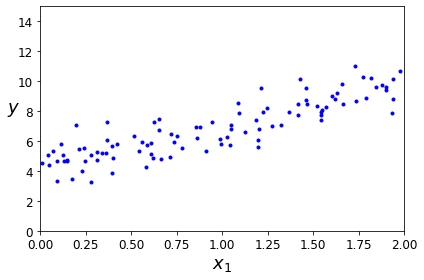

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

## The Normal Equation ***(5 pts)***

We first try to fit a linear model using the Normal Equation.

$$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$$

<mark>TODO-1</mark> Implement the Normal Equation in the following function using numpy. The function returns $\hat{\boldsymbol{\theta}}$.  ***(5 pts)*** 

*Hint: You can use numpy function to avoid using loop to calculate **dot** product.*

In [4]:
def solve_normal_eq(X, y):
    ######## TODO ########
    theta_best = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)    
    ######################
    return theta_best

In [5]:
X_b = np.c_[np.ones((len(X), 1)), X]
theta_best = solve_normal_eq(X_b, y)
theta_best

array([[4.21509616],
       [2.77011339]])

We can visualize the trained model as follows.

save plot: linear_model_predictions_plot


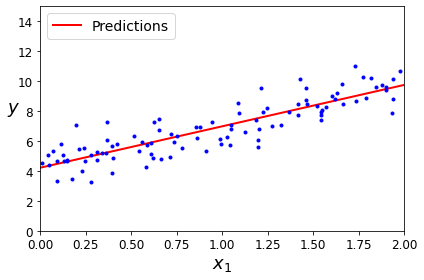

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict
X_new

plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

## Gradient Descent Methods ***(5 pts)***

We can also fit the linear model by using the gradient descent method. The gradient of the MSE loss can be written as follows:

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m}\sum_{i=1}^{m} (\boldsymbol{\theta}^T \mathbf{x}^{(i)} - y^{(i)})x_j^{(i)}
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$

Then, the model parameter is updated as follows. Here, $\eta$ is the learning rate.

$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
$

<mark>TODO-2</mark> Implement the following function that updates the model parameter by gradient descent and returns the updated model parameter theta_next. ***(3 pts)***

In [7]:
def linear_mse_gradient_update(X, y, theta, m, eta):
    ######## TODO ########
    theta_next = theta - (eta*2/m) * np.dot(X.T, np.dot(X, theta) - y)
    #############
    # #########
    return theta_next

The following function, plot_gradient_descent, is to visualize the first 10 models generated by gradient descent

In [8]:
theta_path_bgd = []
X_b = np.c_[np.ones((100, 1)), X]

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        theta = linear_mse_gradient_update(X_b, y, theta, m, eta)
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

<mark>TODO-3</mark> Try various learning rates and find one that converges well. ***(2 pts)***

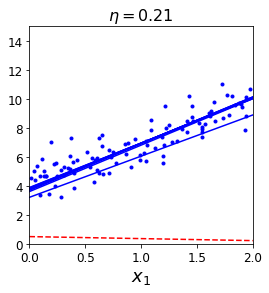

In [9]:
######## TODO ########
eta_best = 0.21
######################

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(4,4))
plot_gradient_descent(theta, eta=eta_best, theta_path=theta_path_bgd)

## Mini-batch GD (Stochastic Gradient Descent) ***(15 pts)***

Now we will train the same model using stochastic gradient descent.

In [10]:
n_iterations = 200
minibatch_size = 20

theta = np.random.randn(2,1)

t0, t1 = 200, 1000
def learning_schedule(epoch):
    return t0 / (epoch + t1)

<mark>TODO-4</mark> Implement the following function, step_sgd(). ***(5 pts)*** \\
The function should
1. select a minibatch
2. compute the gradient using the mini-batch
3. update the parameter by the computed gradient and following the learning_schedule.

In [11]:
def step_sgd(X, y, theta, i, minibatch_size, epoch):
    ######## TODO ########
    #step of the minibatch
    theta = linear_mse_gradient_update(X[i*minibatch_size:(i+1)*minibatch_size, :], y[i*minibatch_size:(i+1)*minibatch_size, :], theta, minibatch_size, learning_schedule(epoch))
    # start_ind = [ind for ind in range(0, X.shape[0], minibatch_size)]
    # for _ in range(epoch):
    #     for indx in start_ind:
    #         theta = linear_mse_gradient_update(X[indx:indx+minibatch_size, :], y[indx:indx+minibatch_size, :], theta, minibatch_size, eta_best)
    #######################
    return theta 

<mark>TODO-5</mark> Implement the following function to shuffle the whole data once in an epoch. ***(5 pts)***

Use np.random.permutation() to randomly shuffle indice.



In [12]:
def shuffle_data(X_b, y):
    ######## TODO ########
    shuffled_indices = np.random.permutation(X_b.shape[0])
    X_b_shuffled, y_shuffled = X_b[shuffled_indices, :], y[shuffled_indices, :]
    ######################
    return X_b_shuffled, y_shuffled

<mark>TODO-6</mark> Using the above two functions implement the following fuction performing SGD updates for one epoch. ***(5 pts)***

To make the remaining code work, add the following line whenever the parameter is updated.
> theta_path_sgd.append(theta)

In [13]:
def train_one_epoch(theta, X_b, y, m, minibatch_size, epoch, theta_path_sgd):
    ######## TODO ########
    # TODO
    X_bs, y_bs = shuffle_data(X_b, y)
    for i in range(0, m, minibatch_size):
        theta = step_sgd(X_bs, y_bs, theta, i, minibatch_size, epoch)
        theta_path_sgd.append(theta)
    ######################
    return theta, theta_path_sgd

Now you can train your model as follows

In [14]:
m = len(y)
theta_path_sgd = [] # to store the sgd update path
theta = np.random.randn(2,1)

X_b = np.c_[np.ones((100, 1)), X]

for epoch in range(n_iterations):
    theta, theta_path_sgd = train_one_epoch(theta, X_b, y, m, minibatch_size, epoch, theta_path_sgd)

Let's plot.

save plot: gradient_descent_paths_plot


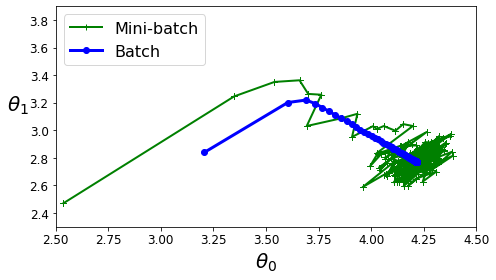

In [15]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

## Polynomial Regresssion

Let's make a new dataset

In [ ]:
import numpy as np
import numpy.random as rnd

np.random.seed(45)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

save plot: quadratic_data_plot


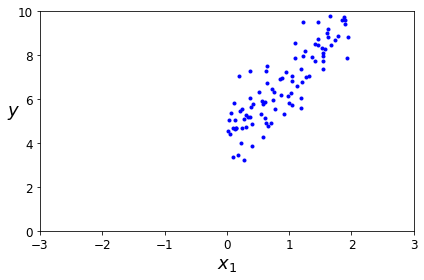

In [16]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

Using the sklearn package, let's extract more features of higher degree

In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([0.74908024])

In [18]:
X_poly[0]

array([0.74908024, 0.5611212 ])

Let's fit the model using the LinearRegression package in sklearn 

In [19]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.56140272]), array([[1.63887939, 0.5810637 ]]))

save plot: quadratic_predictions_plot


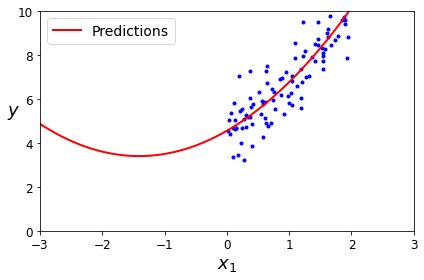

In [20]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

### Try degree = 10, 20, 30 and plot

The previous example used only degree=2. Now let's try higher degrees and see how it overfits according to the degree. 

save plot: high_degree_polynomials_plot


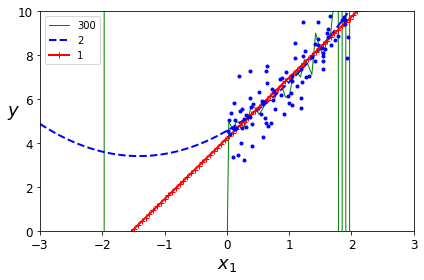

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

## Softmax Classification ***(25 pts)***

Prepare dataset

In [22]:
from sklearn import datasets
iris = datasets.load_iris()

In [23]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Add bias terms to all samples

In [24]:
X = iris["data"][:, (2, 3)]  # length and width as the features
y = iris["target"]

In [25]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

<mark>TODO-7</mark> Split dataset into train, validation, and test sets. ***(3 pts)***

Use np.random.permutation() to randomly shuffle indice and retrieve each dataset in order of train, validation and test.

In [26]:
def train_test_split(X, y, total_size, train_size, validation_size, test_size):
    ######## TODO ########
    shuffled_indices = np.random.permutation(total_size)
    X, y = X[shuffled_indices], y[shuffled_indices]
    X_train, y_train, X_valid, y_valid = X[:train_size], y[:train_size], X[train_size:train_size+validation_size], y[train_size:train_size+validation_size]
    X_test, y_test = X[train_size+validation_size:train_size+validation_size+test_size], y[train_size+validation_size:train_size+validation_size+test_size]
    ######################
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [27]:
np.random.seed(2042)

test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

X_train, y_train, X_valid, y_valid, X_test, y_test = train_test_split(X_with_bias, y, total_size, train_size, validation_size, test_size)

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). 

<mark>TODO-8</mark> Write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance. ***(3 pts)***

In [28]:
def to_one_hot(y, n_classes):
    ######## TODO ########
    Y_one_hot = np.zeros((len(y), n_classes))
    for i in range(len(y)):
        Y_one_hot[i, y[i]] = 1
    ######################
    return Y_one_hot

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [29]:
Y_train_one_hot = to_one_hot(y_train, 3)
Y_valid_one_hot = to_one_hot(y_valid, 3)
Y_test_one_hot = to_one_hot(y_test, 3)

<mark>TODO-9</mark> Now let's implement the Softmax function. Recall that it is defined by the following equation: ***(3 pts)***


$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [30]:
def softmax(logits):
    ####### TODO ########
    probs = np.exp(logits)/np.sum(np.exp(logits), axis=1).reshape(-1, 1)
    #####################
    return probs

We are almost ready to start training. Let's define the number of inputs and outputs:

In [31]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. 

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

and its gradient w.r.t. the free parameters is:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So, you can add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

<mark>TODO-10</mark> Implement the following three functions: ***(3 pts each)***
1. cross_entropy()
2. gradient() 
3. predict()

In [32]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7      # for numerical stability of cross entropy loss

class MySoftmaxClassifier():
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.theta = np.random.randn(n_inputs, n_outputs)
        return
    
    def cross_entropy(self, Y_target, Y_pred):
        ####### TODO #########
        loss = (-1/m) * np.sum(np.dot(Y_target.T, np.log(Y_pred + epsilon)))
        ######################
        return loss 
    
    def gradient(self, Y_target, Y_pred, X_train):    
        ####### TODO #########
        gradients = (1/m) * np.dot(X_train.T, (Y_pred - Y_target)) #########
        ######################
        return gradients
    
    def predict(self, X):
        ####### TODO #########
        Y_proba = softmax(np.dot(X, self.theta))
        ######################
        return Y_proba
        
    def fit(self, X_train, Y_train_one_hot):
        for iteration in range(n_iterations):
            Y_proba = self.predict(X_train)
            if iteration % 500 == 0:
                loss = self.cross_entropy(Y_train_one_hot, Y_proba)
                print(iteration, loss)
            gradients = self.gradient(Y_train_one_hot, Y_proba, X_train)
            self.theta = self.theta - eta * gradients
            
    def validation_score(self, X_valid, y_valid):
        y_valid_one_hot = to_one_hot(y_valid, self.n_classes)
        logits = X_valid.dot(self.theta)
        Y_proba = softmax(logits)
        Y_predict = np.argmax(Y_proba, axis=1)
        accuracy_score = np.mean(Y_predict == y_valid)
        
        xent_loss = self.cross_entropy(y_valid_one_hot, Y_proba)
        
        return accuracy_score, xent_loss

In [33]:
np.random.seed(49)
model = MySoftmaxClassifier(n_classes=3)
model.fit(X_train, Y_train_one_hot)

0 16.485021537588967
500 6.014877638362185
1000 7.506194505240764
1500 8.550036027088668
2000 9.381415775212222
2500 10.080905052398249
3000 10.6873355392371
3500 11.222980132939304
4000 11.701929322681485
4500 12.133697101917917
5000 12.52502994581208


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [34]:
model.theta

array([[ 7.87507999,  0.87155185, -9.94550076],
       [-1.18798594,  0.64011512,  1.1627223 ],
       [-3.34953639, -0.55684534,  4.46728896]])

Let's make predictions for the validation set and check the accuracy score: 

In [35]:
model.validation_score(X_valid, y_valid)

(0.9666666666666667, 4.000557619479959)

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of  ℓ2  regularization.

$L2(J(\mathbf{\Theta}) )=
 \dfrac{λ}{2}\sum\limits_{k=1}^{K}\theta^2$

The following class inherits the MySoftmaxClassifier you have already implemented. \\
<mark>TODO-11</mark> Now, implement the cross_entropy() and gradient() function so that it has ℓ2 regularization. ***(2 pts each)***

In [36]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7      # for numerical stability of cross entropy loss
alpha = 0.1    # regularization hyperparameter

class MySoftmaxClassifierL2(MySoftmaxClassifier):
    def __init__(self, n_classes):
        MySoftmaxClassifier.__init__(self, n_classes)
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        return 
    
    def cross_entropy(self, Y_target, Y_pred):
        ####### TODO #########
        loss = ((-1/m) * np.sum(np.dot(Y_target.T, np.log(Y_pred + epsilon)))) + (alpha/2) * np.sum(np.square(self.theta))
        ######################
        return loss 
    
    def gradient(self, Y_target, Y_pred, X_train):
        ####### TODO #########
        gradients = (1/m) * np.dot(X_train.T, (Y_pred - Y_target)) + alpha*np.sum(self.theta)
        ######################
        return gradients

In [37]:
np.random.seed(50)
model = MySoftmaxClassifierL2(n_classes=3)
model.fit(X_train, Y_train_one_hot)

0 23.300156646478154
500 7.24473095910435
1000 9.921810920723466
1500 12.081327276745743
2000 13.962467329649991
2500 15.655279564244847
3000 17.206356517465206
3500 18.644071483765728
4000 19.987411024966416
4500 21.24990127202643
5000 22.44162715952688


We see that the validation accuracy is improved with the regularization.

In [38]:
model.validation_score(X_valid, y_valid)

(0.9666666666666667, 13.902938359251339)

<mark>TODO-12</mark> Implement early stopping in the following class. ***(3 pts)***

Early stopping finishes training if the validation loss increases. Print the following when early stopping happens
> print(iteration, val_loss, "early stopping!")

In [39]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1    # regularization hyperparameter

class MySoftmaxClassifierES(MySoftmaxClassifierL2):
    def __init__(self, n_classes):
        MySoftmaxClassifierL2.__init__(self, n_classes)
        self.best_loss = np.infty
        return 
    
    def fit(self, X_train, Y_train_one_hot, X_valid, y_valid):
        for iteration in range(n_iterations):
            Y_proba = self.predict(X_train)
            gradients = self.gradient(Y_train_one_hot, Y_proba, X_train)
            self.theta = self.theta - eta * gradients
            _, val_loss = self.validation_score(X_valid, y_valid)

            if iteration % 500 == 0:
                print(iteration, val_loss)
                
            ###### TODO ########
            if val_loss < self.best_loss:
                self.best_loss = val_loss
            else:
                print(iteration, val_loss, "early stopping!")
                break
            #####################

In [40]:
np.random.seed(51)
model = MySoftmaxClassifierES(n_classes=3)
model.fit(X_train, Y_train_one_hot, X_valid, y_valid)

0 2.761730599993412
31 1.3353056606431364 early stopping!


With early stopping, we see similar performance while training a smaller number of iterations.

In [41]:
model.validation_score(X_valid, y_valid)

(0.36666666666666664, 1.3353056606431364)

# Evaluation

In [42]:
### Evaluation Cell ### 
### The execution result of this cell has to be in the submission. But, never change this cell.

import numpy as np

np.random.seed(376)
eval_eta = 1
eval_minibatch_size=3
eval_theta_path_sgd = []

eval_X = 2 * np.random.rand(10, 1)
eval_y = 4 + 3 * eval_X + np.random.randn(10, 1)

eval_X_b = np.c_[np.ones((len(eval_X), 1)), eval_X]
todo_1 = solve_normal_eq(eval_X_b, eval_y)
print("TODO#1 Result: \n", todo_1) # independent

eval_theta = np.random.randn(2,1)
todo_2 = linear_mse_gradient_update(eval_X_b, eval_y, eval_theta, len(X), 1)
print("\nTODO#2 Result: \n", todo_2) # independent

eval_theta = np.random.randn(2,1)
todo_4 = step_sgd(eval_X_b, eval_y, eval_theta, 0, 3, eval_eta)
print("\nTODO#4 Result: \n", todo_4) # independent

todo_5, _ = shuffle_data(eval_X, eval_y)
print("\nTODO#5 Result: \n", todo_5[:5]) # independent

todo_6, _ = train_one_epoch(theta, eval_X_b, eval_y, len(eval_y), 3, eval_eta, eval_theta_path_sgd)
print("\nTODO#6 Result: \n", todo_6) # dependent on todo 4-6

eval_test_ratio = 0.2
eval_validation_ratio = 0.2
eval_total_size = len(eval_X_b)

eval_test_size = int(eval_total_size * eval_test_ratio)
eval_validation_size = int(eval_total_size * eval_validation_ratio)
eval_train_size = eval_total_size - eval_test_size - eval_validation_size

eval_X_train, eval_y_train, eval_X_valid, eval_y_valid, _, todo_7 = train_test_split(eval_X_b, eval_y, eval_total_size, eval_train_size, eval_validation_size, eval_test_size)
print("\nTODO#7 Result: \n", todo_7) # independent
print("\nTODO#7 Result: train len: {}, val len: {}, test len: {}\n".format(len(eval_X_train), len(eval_X_valid), len(todo_7)))

todo_8 = to_one_hot(np.array([0, 1, 2, 5, 4, 3]), n_classes=6)
print("\nTODO#8 Result: \n", todo_8) # independent

todo_9 = softmax(np.array([[1, 2, 3, 4], [-1, -2, -3, -1]]))
print("\nTODO#9 Result: \n", todo_9) # independent

eval_X_train = np.array([[1, 2], [3, 4]])
eval_onehot = np.array([[1, 0, 0], [0, 1, 0]])
eval_X_valid = np.array([[2, 3], [4, 5]])
eval_y_valid = np.array([[0], [2]])

classification_model = MySoftmaxClassifier(n_classes=3)
classification_model.theta = np.random.randn(2, 3)
eval_y_proba = classification_model.predict(eval_X_train)
eval_l = classification_model.cross_entropy(eval_onehot, eval_y_proba)
eval_grad = classification_model.gradient(eval_onehot, eval_y_proba, eval_X_train)

print("\nTODO#10-1 Result: \n", eval_y_proba) # independent
print("\nTODO#10-2 Result: \n", eval_l) # dependent on TODO 10-1
print("\nTODO#10-3 Result: \n", eval_grad) # dependent on TODO 10-1

l2_classification_model = MySoftmaxClassifierL2(n_classes=3)
l2_classification_model.theta = np.random.randn(2, 3)
l2_classification_model.n_outputs = 3
eval_y_proba = l2_classification_model.predict(eval_X_train)
eval_l = l2_classification_model.cross_entropy(eval_onehot, eval_y_proba)
eval_grad = l2_classification_model.gradient(eval_onehot, eval_y_proba, eval_X_train)

print("\nTODO#11-1 Result: \n", eval_y_proba) # indepedent
print("\nTODO#11-2 Result: \n", eval_l) # dependent on TODO 11-1
print("\nTODO#11-3 Result: \n", eval_grad) # dependent on TODO 11-1

print("\nTODO#12 Result: \n")

es_model = MySoftmaxClassifierES(n_classes=3)
es_model.theta = np.random.randn(2, 3)
es_model.n_outputs = 3
es_model.fit(eval_X_train, eval_onehot, eval_X_valid, eval_y_valid)

TODO#1 Result: 
 [[3.60043689]
 [3.44071344]]

TODO#2 Result: 
 [[1.46759341]
 [1.21315488]]

TODO#4 Result: 
 [[2.23165314]
 [5.35987543]]

TODO#5 Result: 
 [[0.68827046]
 [1.89257362]
 [1.42154966]
 [1.59358978]
 [1.13315248]]

TODO#6 Result: 
 [[4.21436997]
 [2.92983234]]

TODO#7 Result: 
 [[6.04158526]
 [9.44196144]]

TODO#7 Result: train len: 6, val len: 2, test len: 2


TODO#8 Result: 
 [[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]

TODO#9 Result: 
 [[0.0320586  0.08714432 0.23688282 0.64391426]
 [0.3994863  0.1469628  0.05406459 0.3994863 ]]

TODO#10-1 Result: 
 [[9.82288090e-01 1.65148243e-02 1.19708581e-03]
 [9.99986199e-01 1.37068034e-05 9.37967203e-08]]

TODO#10-2 Result: 
 0.4166217980815325

TODO#10-3 Result: 
 [[ 3.31360743e-02 -3.31493784e-02  1.33040800e-05]
 [ 4.40502331e-02 -4.40768392e-02  2.66060756e-05]]

TODO#11-1 Result: 
 [[1.30729536e-02 1.28153211e-01 8.58773836e-01]
 [5.81893408e